# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import random
import torch
import numpy as np
from infra.game import Game
import csv
import math
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
from dqn_agent import Agent
# one suit case 
# state space: initial state 104!/(8!)^13 * (C_54^10 + ... + C_104^10) +
# 91!/(8!)^12 * (C_41^10 + ... + C_91^10)... + 13!*C_13^10 + 1
# action space: deal and move 10 columns move to the other 9 cols, move at most 12 cards, 10*9*12+1
# According to this method, we can simply say the size of state space equals to 104 
# And one way is we record the know of the numbr of the cards (flip equal to 0) and record 
# 10 columns (num)  + stock number + how many completed
# the action should be move or deal 
# (avoid too complex action space, we set every move we only move the valid move 0)

agent = Agent(state_size=115, action_size=2, seed=0)
# watch an untrained agent
game = Game(0)
game.createGame((0, 0, 0, 0))
game.startGame()
print(game)
for i in range(3):
    state = np.array(game.getStateForDQN())
    # how to use agent to get the actions / how to modify the actions
    action = agent.act(state)
    game.performMovesForDQN(action)
    print(game)


-♤  J- -♤  7- -♤  2- -♤  6- -♤  8- -♤  A- -♤  J- -♤  K- -♤  K- -♤ 10-
-♤  7- -♤ 10- -♤  2- -♤  K- -♤  5- -♤  J- -♤  Q- -♤  K- -♤  2- -♤  7-
-♤  4- -♤  K- -♤  6- -♤  A- -♤  9- -♤ 10- -♤  4- -♤  9- -♤  7- -♤  8-
-♤  3- -♤  4- -♤  2- -♤  A- -♤  4- -♤  5- -♤  2- -♤  9- -♤  8- -♤  2-
-♤  Q- -♤  8- -♤  J- -♤  K-  ♤  J   ♤  A   ♤  3   ♤  6   ♤  9   ♤  3 
 ♤  9   ♤  A   ♤  Q   ♤  5                                           
Game#0 Score: 500   Moves: 0   Completed: 0   Undealt: 5
-♤  J- -♤  7- -♤  2- -♤  6- -♤  8- -♤  A- -♤  J- -♤  K- -♤  K- -♤ 10-
-♤  7- -♤ 10- -♤  2- -♤  K- -♤  5- -♤  J- -♤  Q- -♤  K- -♤  2- -♤  7-
-♤  4- -♤  K- -♤  6- -♤  A- -♤  9- -♤ 10- -♤  4- -♤  9- -♤  7- -♤  8-
-♤  3- -♤  4- -♤  2- -♤  A-  ♤  4  -♤  5- -♤  2- -♤  9- -♤  8- -♤  2-
-♤  Q- -♤  8- -♤  J- -♤  K-         ♤  A   ♤  3   ♤  6   ♤  9   ♤  3 
 ♤  9   ♤  A   ♤  Q   ♤  5                                           
               ♤  J                                                  
Game#0 Score: 498   Moves: 2   Co

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

Episode 100	Average Score: 479.10 	Completed: 0
Episode 200	Average Score: 481.07 	Completed: 0
Episode 300	Average Score: 490.38 	Completed: 01
Episode 400	Average Score: 492.75 	Completed: 01
Episode 500	Average Score: 477.10 	Completed: 0
Episode 600	Average Score: 480.72 	Completed: 0
Episode 700	Average Score: 490.15 	Completed: 01
Episode 800	Average Score: 490.61 	Completed: 01
Episode 900	Average Score: 491.15 	Completed: 0
Episode 1000	Average Score: 488.50 	Completed: 0
4


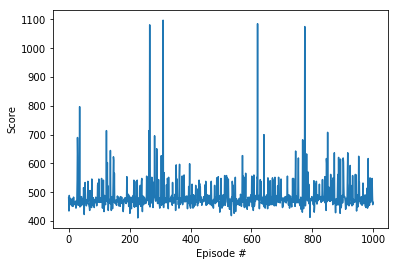

In [8]:
def dqn(n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    numCompleted = 0
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        game = Game(i)
        game.createGame((0, 0, 0, 0))
        game.startGame()
        score = game.score
        moves = game.getValidMoves()
        completed = 0
        # one game till win the game or cannot move
        while not game.won() and moves:
            state = np.array(game.getStateForDQN())
            action = agent.act(state, eps)
            game.performMovesForDQN(action)
            next_state = np.array(game.getStateForDQN())
            reward = game.score - score
            agent.step(state, action, reward, next_state, game.won())
            moves = game.getValidMoves()
            score = game.score
        if game.won():
            completed = 1
            numCompleted += 1
        scores.append(score)              # save most recent score
        scores_window.append(score)       # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} \tCompleted: {}'.format(i_episode, score, completed), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} \tCompleted: {}'.format(i_episode, np.mean(scores_window), numCompleted))
        if numCompleted * 1.0 / i_episode > 0.45:
            print('\nEnvironment solved in {:d} episodes!\tNumber of complted game: {:.2f}'.format(i_episode, numCompleted))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
        elif i_episode == n_episodes+1:
            print('\nRunning all {:d} episodes!\tNumber of complted game: {:.2f}'.format(i_episode, numCompleted))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores, numCompleted

scores, numCompleted = dqn()

# plot the scores
print(numCompleted)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [15]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

game = Game(10000)
game.createGame((0, 0, 0, 0))
game.startGame()
print(game)
moves = game.getValidMoves()
while not game.won() and moves:
    state = np.array(game.getStateForDQN())
    action = agent.act(state)
    game.performMovesForDQN(action)
    moves = game.getValidMoves()
print(game)
print('Game#%d [%s] Score: %d   Moves: %d   Completed: %d' %
                      (game.id, 'Won' if game.won() else 'Lost', game.score, game.moves, game.completed))

# baseline
game = Game(10000)
game.createGame((0, 0, 0, 0))
game.startGame()
moves = game.getValidMoves()
while not game.won() and moves:
    game.performMoves(moves[0])
    moves = game.getValidMoves()
print(game)
print('Game#%d [%s] Score: %d   Moves: %d   Completed: %d' %
                      (game.id, 'Won' if game.won() else 'Lost', game.score, game.moves, game.completed))

-♤  A- -♤  4- -♤  4- -♤  5- -♤  3- -♤ 10- -♤ 10- -♤  J- -♤  4- -♤  3-
-♤  3- -♤  7- -♤  K- -♤  3- -♤  8- -♤  7- -♤  J- -♤  2- -♤  9- -♤  4-
-♤ 10- -♤  8- -♤  4- -♤  J- -♤  A- -♤  6- -♤  9- -♤  J- -♤  K- -♤  7-
-♤  A- -♤  8- -♤  2- -♤  7- -♤  2- -♤  J- -♤ 10- -♤  6- -♤  Q- -♤  Q-
-♤  A- -♤  K- -♤  5- -♤  3-  ♤  J   ♤  5   ♤  2   ♤  4   ♤  5   ♤  K 
 ♤  9   ♤  A   ♤  4   ♤  9                                           
Game#10000 Score: 500   Moves: 0   Completed: 0   Undealt: 5
-♤  A- -♤  4- -♤  4- -♤  5- -♤  3- -♤ 10- -♤ 10- -♤  J- -♤  4- -♤  3-
-♤  3- -♤  7- -♤  K- -♤  3- -♤  8- -♤  7- -♤  J- -♤  2- -♤  9- -♤  4-
-♤ 10- -♤  8- -♤  4- -♤  J- -♤  A- -♤  6-  ♤  9  -♤  J- -♤  K- -♤  7-
-♤  A- -♤  8-  ♤  2  -♤  7- -♤  2- -♤  J-  ♤  8   ♤  6  -♤  Q- -♤  Q-
-♤  A- -♤  K-        -♤  3-  ♤  J   ♤  5   ♤  7   ♤  Q   ♤  5   ♤  K 
 ♤  9   ♤  A          ♤  9   ♤  Q   ♤ 10   ♤  6   ♤  8   ♤  4   ♤  9 
 ♤  K   ♤  J          ♤  8   ♤  Q   ♤  2   ♤  5   ♤ 10   ♤  6   ♤  8 
 ♤  J   ♤ 10          ♤  6   